# Vehicle Detection Inference

Load the trained YOLO model and perform inference on new images

In [2]:
# Import required libraries
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path

# Load class names from the data configuration
import yaml
with open('vehicle-detection.v21i.yolov11/data.yaml', 'r') as f:
    data_config = yaml.safe_load(f)
    
print("Available classes:", data_config['names'])

Available classes: ['mobil', 'motor']


In [3]:
# Load the trained model (single backend model)
model_path = 'saved_models/clean_traffic_model.pt'
model = YOLO(model_path)

print("Model loaded successfully!")

Model loaded successfully!


In [5]:
# Helper: calculate green time and improvement

def calculate_green_time(car_count, motorcycle_count, base_time=10, time_per_car=6, time_per_motorcycle=5, min_time=15, max_time=60):
    green_time = base_time + (car_count * time_per_car) + (motorcycle_count * time_per_motorcycle)
    return max(min_time, min(green_time, max_time))

def summarize_results(counts, previous_time=60):
    green_time = calculate_green_time(counts['mobil'], counts['motor'])
    improvement_time = previous_time - green_time
    improvement_pct = (improvement_time / previous_time) * 100
    print(f"Recommended Green: {green_time} seconds")
    print(f"Improvement Time vs {previous_time}s: {improvement_time:.1f} seconds")
    print(f"Improvement: {improvement_pct:.2f}%")
    return green_time, improvement_time, improvement_pct


In [6]:
# Function to process image and display results
def detect_vehicles(image_path, conf_threshold=0.25):
    """
    Detect and count vehicles in an image
    """
    # Read image
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    # Run inference
    results = model.predict(img, conf=conf_threshold)[0]
    
    # Initialize counters
    counts = {'mobil': 0, 'motor': 0, 'total': 0}
    
    # Process detections
    for box in results.boxes:
        conf = float(box.conf)
        if conf < conf_threshold:
            continue
            
        cls = int(box.cls)
        class_name = data_config['names'][cls]
        counts[class_name] += 1
        counts['total'] += 1
        
        # Draw bounding box
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        color = (0, 255, 0) if class_name == 'mobil' else (255, 0, 0)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        
        # Add label
        label = f"{class_name} {conf:.2f}"
        cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Add count summary
    summary = f"Total: {counts['total']} | Cars: {counts['mobil']} | Motorcycles: {counts['motor']}"
    cv2.putText(img, summary, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Display results
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Vehicle Detection Results')
    plt.show()
    
    print("\nDetection Results:")
    print(f"Total vehicles: {counts['total']}")
    print(f"Cars: {counts['mobil']}")
    print(f"Motorcycles: {counts['motor']}")
    
    return counts


0: 416x416 2 mobils, 5 motors, 176.6ms
Speed: 31.7ms preprocess, 176.6ms inference, 26.0ms postprocess per image at shape (1, 3, 416, 416)


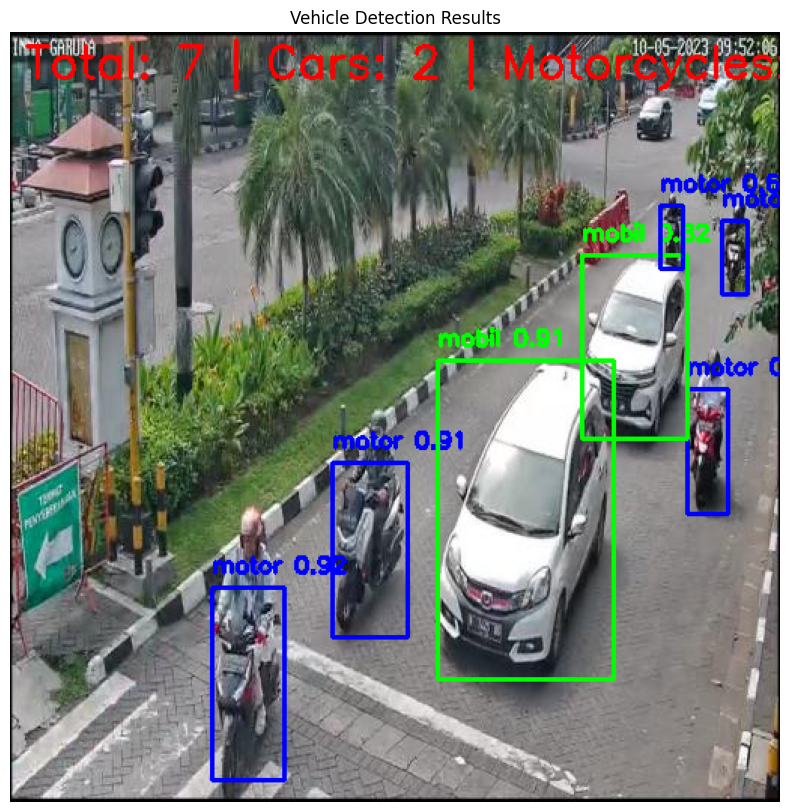


Detection Results:
Total vehicles: 7
Cars: 2
Motorcycles: 5
Recommended Green: 47 seconds
Improvement Time vs 60s: 13.0 seconds
Improvement: 21.67%


(47, 13, 21.666666666666668)

In [7]:
# End-to-end test using the single backend model

# Choose a test image from your dataset
image_path = Path('vehicle-detection.v21i.yolov11/test/images/2023-05-10-15-_png.rf.ede4ef4864720d2d19cac73085637827.jpg')

# Detect and summarize
counts = detect_vehicles(image_path)
summarize_results(counts)
